In [1]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import cv2
import matplotlib.pyplot as plt

from Config.CustomConfig import NucleusConfig
from data.CustomDataset import NucleusDataset
from model.MaskRcnn import MaskRCNN
from Utils import visualize

import warnings
warnings.filterwarnings("ignore")

import tensorflow as tf

Using TensorFlow backend.


In [2]:
gpus = tf.config.experimental.list_physical_devices(device_type='GPU')

for gpu in gpus:
    print(gpu)
    tf.config.experimental.set_memory_growth(gpu, True)

PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [2]:
# ROOT_DIR = os.path.abspath('.')
ROOT_DIR = 'D:\\coursera\\maskrcnn'

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "checkpoint")

ROOT_DIR, MODEL_DIR

('D:\\coursera\\maskrcnn', 'D:\\coursera\\maskrcnn\\checkpoint')

In [4]:
# Training dataset
dataset_train = NucleusDataset()
# dataset_train.load_horse('D:\DataSet\\balloon', "train")
dataset_train.load_nucleus(os.path.join(ROOT_DIR, 'dataset/data-science-bowl-2018'), "train")
dataset_train.prepare()

# Validation dataset
dataset_val = NucleusDataset()
# dataset_val.load_horse('D:\DataSet\\balloon', "val")
dataset_val.load_nucleus(os.path.join(ROOT_DIR, 'dataset/data-science-bowl-2018'), "val")
dataset_val.prepare()

536it [00:00, 96495.28it/s]
134it [00:00, 61124.17it/s]


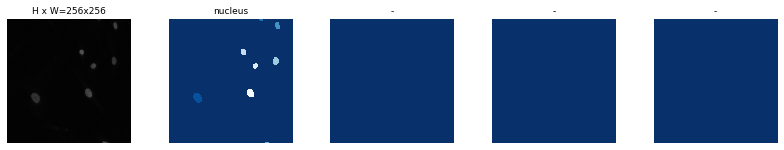

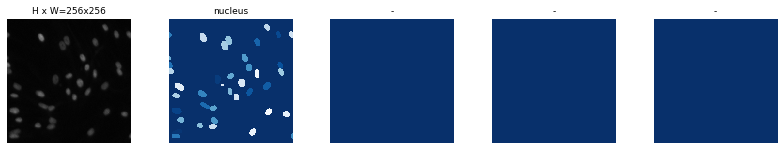

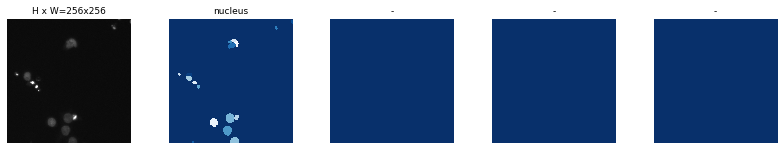

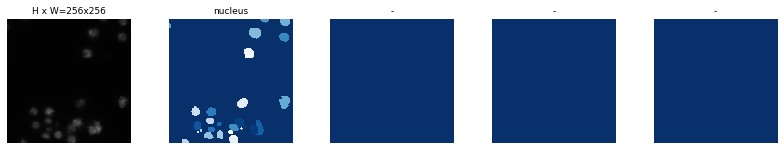

In [5]:
image_ids = np.random.choice(dataset_train.image_ids, 4)
for image_id in image_ids:
    image = dataset_train.load_image(image_id)
    mask, class_ids = dataset_train.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)

In [6]:
config = NucleusConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     4
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        400
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 4
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  512
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  512
IMAGE_MIN_SCALE                2.0
IMAGE_RESIZE_MODE              crop
IMAGE_SHAPE                    [512 512   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE             

In [7]:
#  Local path to trained weights file
# COCO_MODEL_PATH = os.path.join(ROOT_DIR, "pretrain\\mask_rcnn_coco.h5")
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "pretrain/mask_rcnn_coco.h5")

In [8]:
model = MaskRCNN(mode="training", config=config, model_dir=MODEL_DIR)

In [9]:
# Which weights to start with?
init_with = "coco"  # imagenet, coco, or last

if init_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_with == "coco":
    # Load weights trained on MS COCO, but skip layers that
    # are different due to the different number of classes
    # See README for instructions to download the COCO weights
    model.load_weights(COCO_MODEL_PATH, by_name=True,
        exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", "mrcnn_bbox", "mrcnn_mask"]
    )
elif init_with == "last":
    # Load the last model you trained and continue training
    model.load_weights(model.find_last(), by_name=True)

In [10]:
from imgaug import augmenters as iaa

augmentation = iaa.SomeOf((0, 2), [
    iaa.Fliplr(0.5),
    iaa.Flipud(0.5),
    iaa.OneOf([iaa.Affine(rotate=90),
               iaa.Affine(rotate=180),
                iaa.Affine(rotate=270)]),
    iaa.Multiply((0.8, 1.5)),
    iaa.GaussianBlur(sigma=(0.0, 5.0))
])

In [11]:
model.train(dataset_train, dataset_val,
            learning_rate=config.LEARNING_RATE,
            epochs=20,
            augmentation=augmentation,
            layers='heads')


Starting at epoch 0. LR=0.001

Checkpoint Path: /mnt/maskrcnn/checkpoint/nucleus20200610T1629/mask_rcnn_nucleus_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistributed)
mrcnn_mask

In [12]:
model_path = os.path.join(MODEL_DIR, "mask_rcnn_nucleus.h5")
model.keras_model.save_weights(model_path)

inference

In [3]:
from Utils.sample_utils import color_splash
from data.DataGenerator import load_image_gt
from Utils.utils import log

In [4]:
class InferenceConfig(NucleusConfig):
    # Set batch size to 1 to run one image at a time
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    # Don't resize imager for inferencing
    IMAGE_RESIZE_MODE = "pad64"
    # Non-max suppression threshold to filter RPN proposals.
    # You can increase this during training to generate more propsals.
    RPN_NMS_THRESHOLD = 0.7

inference_config = InferenceConfig()

model = MaskRCNN(mode="inference", config=inference_config, model_dir=MODEL_DIR)

In [5]:
model_path = os.path.join(MODEL_DIR, 'mask_rcnn_nucleus.h5')
# Load trained weights
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

Loading weights from  D:\coursera\maskrcnn\checkpoint\mask_rcnn_nucleus.h5


In [6]:
# Validation dataset
dataset_val = NucleusDataset()
dataset_val.load_nucleus('D:\DataSet\\data-science-bowl-2018', "val")
# dataset_val.load_nucleus(os.path.join(ROOT_DIR, 'dataset/data-science-bowl-2018'), "val")
dataset_val.prepare()

134it [00:00, 10356.88it/s]


original_image           shape: (768, 768, 3)         min:    0.00000  max:   36.00000  uint8
image_meta               shape: (14,)                 min:    1.00000  max:  768.00000  float64
gt_class_id              shape: (24,)                 min:    1.00000  max:    1.00000  int32
gt_bbox                  shape: (24, 4)               min:   24.00000  max:  744.00000  int32
gt_mask                  shape: (768, 768, 24)        min:    0.00000  max:    1.00000  bool


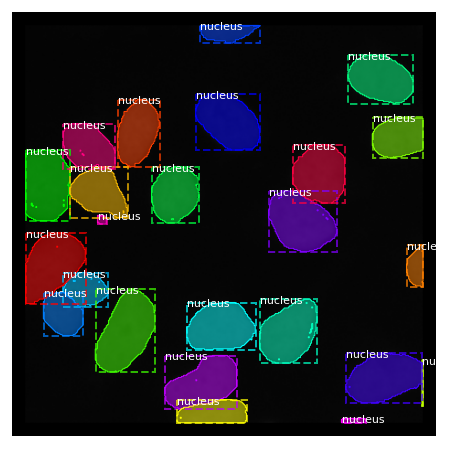

In [15]:
image_id = random.choice(dataset_val.image_ids)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask = load_image_gt(dataset_val, inference_config, image_id, use_mini_mask=False)

log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, dataset_val.class_names, figsize=(8, 8))

In [16]:
results = model.detect([original_image], verbose=1)

r = results[0]

Processing 1 images
image                    shape: (768, 768, 3)         min:    0.00000  max:   36.00000  uint8
molded_images            shape: (1, 1536, 1536, 3)    min: -123.70000  max:  -67.90000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1536.00000  float64
anchors                  shape: (1, 589248, 4)        min:   -0.05896  max:    1.02338  float32


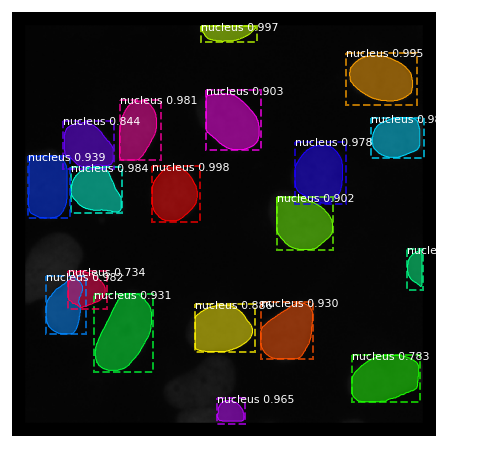

In [17]:
visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], dataset_val.class_names, r['scores'], figsize=(8, 8))

In [7]:
from Utils.evalution_utils import compute_ap
from data.DataGenerator import mold_image
from tqdm import tqdm

In [8]:
# Compute VOC-Style mAP @ IoU=0.5
# Running on 10 images. Increase for better accuracy.
image_ids = np.random.choice(dataset_val.image_ids, 30)
APs = []
for image_id in tqdm(image_ids):
    # Load image and ground truth data
    image, image_meta, gt_class_id, gt_bbox, gt_mask =load_image_gt(dataset_val, inference_config, image_id, use_mini_mask=False)
    molded_images = np.expand_dims(mold_image(image, inference_config), 0)
    # Run object detection
    results = model.detect([image], verbose=0)
    r = results[0]
    # Compute AP
    AP, precisions, recalls, overlaps = compute_ap(gt_bbox, gt_class_id, gt_mask, r["rois"], r["class_ids"], r["scores"], r['masks'])
    APs.append(AP)
    
print("mAP: ", np.mean(APs))

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [09:27<00:00, 18.91s/it]

mAP:  0.7805992686216163
